In [1]:
# Goal for the notebook: Get the block computations of x_sim and T working
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

In [2]:
### Define and test seq_to_x function
x_triv = np.array([1])
x_ohe_A = np.array([1, 0, 0, 0])
x_ohe_C = np.array([0, 1, 0, 0])
x_ohe_G = np.array([0, 0, 1, 0])
x_ohe_T = np.array([0, 0, 0, 1])

char_to_ohe_dict = {
    'A':x_ohe_A,
    'C':x_ohe_C,
    'G':x_ohe_G,
    'T':x_ohe_T
}

def seq_to_x(seq, ohe_spec_str):
    '''
    inputs: seq (DNA), ohe_spec_str
    returns: x, a one-hot encoding
    '''
    L = len(seq)
    x_components = []
    
    ohe_spec_str_parts = ohe_spec_str.split('+')
    for part in ohe_spec_str_parts:
        
        # Add in trivial component
        if part=='.':
            x_components.append(x_triv)
        else:
            positions = [int(p) for p in part.split('x')]
            assert len(positions) > 0
            x_irr = x_triv
            while len(positions) > 0:
                pos = positions.pop(-1)
                c = seq[pos]
                x_l = char_to_ohe_dict[c]
                x_irr = np.kron(x_irr, x_l)
            x_components.append(x_irr)
    
    # Create x
    x = np.concatenate(x_components)
    return x

In [3]:
### Define and test ohe_spec_to_T function

# Trivial matrix
T_triv = sp.csr_array([[1]])

# ohe_to_block for single position
T_ohe = sp.csr_array([
    [1, 1, 1, 1],
    [1, 0, 0, -1],
    [0, 1, 0, -1],
    [0, 0, 1, -1]
])
T_ohe_inv = sp.csr_matrix(np.linalg.inv(T_ohe.todense()))

alpha = 4
import pdb
def ohe_spec_to_T(ohe_spec_str):
    '''
    input: ohe_spec_str
    output: T (s.t. T x = x_factored)
    '''
    parts = ohe_spec_str.split('+')
    diag_mats = []
    diag_mats_inv = []
    for part in parts:
        if part == '.':
            T_part = T_triv
            T_part_inv = T_triv
        else:
            bits = part.split('x')
            T_part = T_triv
            T_part_inv = T_triv
            for bit in part.split('x'):
                m = T_part.shape[0]

                # Compute kronecker product
                T_part = sp.kron(T_part, T_ohe)
                T_part_inv = sp.kron(T_ohe_inv,T_part_inv)
        diag_mats.append(T_part)
        diag_mats_inv.append(T_part_inv)
    T = sp.block_diag(diag_mats, format='csr')
    T_inv = sp.block_diag(diag_mats_inv, format='csr')
    return T, T_inv

In [4]:
### Define and test ohe_spec_to_T function

alpha=4
I_triv = np.eye(1, dtype=np.int64)
I_ohe = np.eye(alpha, dtype=np.int64)
import pdb
def ohe_spec_to_B(ohe_spec_str):
    '''
    input: ohe_spec_str
    output: T (s.t. T x = x_factored)
    '''
    parts = ohe_spec_str.split('+')
    diag_mats = []
    diag_mats_inv = []
    for part in parts:
        if part == '.':
            B_part = I_triv
            B_part_inv = I_triv
        else:
            bits = part.split('x')
            B_part = I_triv
            B_part_inv = I_triv
            for bit in part.split('x'):
                m = B_part.shape[0]

                # Compute kronecker product
                B_part = sp.kron(B_part, I_ohe)
                B_part_inv = sp.kron(B_part_inv, I_ohe)

                # Fix up row orderd (# Is this where this goes?)
                i_vals = list(range(m*alpha))
                j_vals = [alpha*i for i in range(m)] + [i-m+1+(i-m)//(alpha-1) for i in range(m,m*alpha)]
                data = m*alpha*[1]
                new_B = sp.coo_array((data, (i_vals, j_vals)), shape=(alpha*m,alpha*m)).tocsr()
                B_part = new_B@B_part
                #pdb.set_trace()
                B_part_inv = B_part_inv@(new_B.T)
        diag_mats.append(B_part)
        diag_mats_inv.append(B_part_inv)
    B = sp.block_diag(diag_mats, format='csr')
    B_inv = sp.block_diag(diag_mats_inv, format='csr')
    return B, B_inv

In [5]:
def my_expand(x):
    """
    Expands a list of lists. Simulates product expansion
    """
    if len(x) >= 1:
        a = x[0]
        b = x[1:]
        b_exp = my_expand(b)
        c = [[y]+z for y in a for z in b_exp]        
        return c
    else:
        return [x]

my_expand([['0', '1', '3'], ['4','5'], ['6']])

[['0', '4', '6'],
 ['0', '5', '6'],
 ['1', '4', '6'],
 ['1', '5', '6'],
 ['3', '4', '6'],
 ['3', '5', '6']]

In [6]:
### Convert OHE to SIM spec
def ohe_to_sim_spec(ohe_spec_str):
    a = ohe_spec_str.split('+')
    b = [z.split('x') for z in a]
    for i in range(len(b)):
        for j in range(len(b[i])):
            z = b[i][j]
            if z!='.':
                b[i][j]=['.',z]
    
    # Recursive expansion
    c = []
    for i, b_el in enumerate(b):
        if isinstance(b_el, str):
            c.append([b_el])
        elif isinstance(b_el, list) and len(b_el)>=1:
            c.extend(my_expand(b_el))

    # Remove redundant factors of '.'
    sim_spec_list = []
    for x in c:
        y = [z for z in x if z!='.']
        if len(y)==0:
            y = ['.']
        sim_spec_list.append(y)
    sim_spec_str = '+'.join(['x'.join(z) for z in sim_spec_list])
    return sim_spec_str

In [7]:
### Define and test seq_to_x function
x_triv = np.array([1])
x_sim_A = np.array([1, 0, 0])
x_sim_C = np.array([0, 1, 0])
x_sim_G = np.array([0, 0, 1])
x_sim_T = np.array([-1, -1, -1])

char_to_sim_dict = {
    'A':x_sim_A,
    'C':x_sim_C,
    'G':x_sim_G,
    'T':x_sim_T
}

def seq_to_x_dist(seq, sim_spec_str):
    '''
    inputs: seq (DNA), ohe_spec_str
    returns: x, a one-hot encoding
    '''
    L = len(seq)
    x_components = []
    
    sim_spec_str_parts = sim_spec_str.split('+')
    for part in sim_spec_str_parts:
        
        # Add in trivial component
        if part=='.':
            x_components.append(x_triv)
        else:
            positions = [int(p) for p in part.split('x')]
            assert len(positions) > 0
            x_irr = x_triv
            while len(positions) > 0:
                pos = positions.pop(-1)
                c = seq[pos]
                x_l = char_to_sim_dict[c]
                x_irr = np.kron(x_irr, x_l)
            x_components.append(x_irr)
    
    # Create x
    x = np.concatenate(x_components)
    return x

In [8]:
# Test code
seq = 'AAA'
ohe_spec_str = '0x1x2'
sim_spec_str = ohe_to_sim_spec(ohe_spec_str)
x_ohe = seq_to_x(seq, ohe_spec_str)
x_dist = seq_to_x_dist(seq, sim_spec_str)
T, T_inv = ohe_spec_to_T(ohe_spec_str)
B, B_inv = ohe_spec_to_B(ohe_spec_str)
print('seq:', seq)
print('ohe_spec_str: ', ohe_spec_str)
print('sim_spec_str: ', sim_spec_str)
print('M: ', len(x_ohe))
print('x_ohe: ', x_ohe)
print('x_dist: ', x_dist)
print('B@T@x_ohe: ', B@T@x_ohe)
print('T@x_ohe == x_dist:', all(B@T@x_ohe == x_dist))

seq: AAA
ohe_spec_str:  0x1x2
sim_spec_str:  .+2+1+1x2+0+0x2+0x1+0x1x2
M:  64
x_ohe:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x_dist:  [1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
B@T@x_ohe:  [1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
T@x_ohe == x_dist: True


In [9]:
import itertools
def make_all_seqs(L):
    return [''.join(x) for x in itertools.product(['A','C','G','T'], repeat=L)]

In [10]:
# Test T@x_ohe == x_dist for all possible sequences of a given length
L = 4
ohe_spec_str = '.+0+1+2+3+0x1+1x2+2x3'
sim_spec_str = ohe_to_sim_spec(ohe_spec_str)
T, T_inv = ohe_spec_to_T(ohe_spec_str)
B, B_inv = ohe_spec_to_B(ohe_spec_str)
all_seqs = make_all_seqs(L)
num_matches = 0
for seq in all_seqs:
    x_ohe = seq_to_x(seq, ohe_spec_str)
    x_dist = seq_to_x_dist(seq, sim_spec_str)
    match = all(B@T@x_ohe == x_dist)
    if match:
        num_matches += 1
    else:
        print(f'mismatch for {seq}')
    
print(f'T@x_ohe == x_dist for {num_matches}/{len(all_seqs)} seqs')

T@x_ohe == x_dist for 256/256 seqs


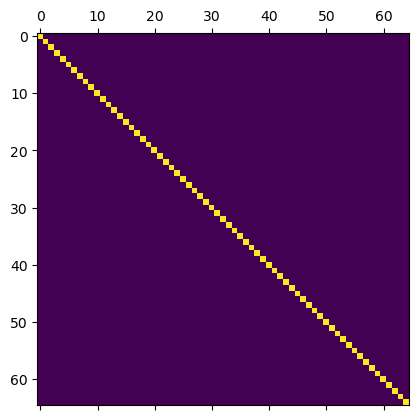

In [11]:
plt.matshow(((T_inv@B_inv)@(B@T)).todense())